In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
pip install audiomentations -q

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/genriflow')

from preprocessing import load_and_process_gtzan

X_train, X_test, X_val, y_train, y_test, y_val = load_and_process_gtzan(
    gtzan_path='/content/drive/MyDrive/gtzan_dataset/Data/genres_original',
    output_file = "/content/drive/MyDrive/Colab Notebooks/genriflow/processed_data.pkl",
    n_songs_per_genre=10,
    noise='weak',
    n_augmentations=0
)


In [ ]:
import pickle
import numpy as np

with open("/content/drive/MyDrive/Colab Notebooks/genriflow/processed_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

X = np.concatenate([data_dict['X_train'], data_dict['X_test'], data_dict['X_val']], axis=0)
y = np.concatenate([data_dict['y_train'], data_dict['y_test'], data_dict['y_val']], axis=0)

print("Data loaded successfully!")
print("X shape:", X.shape)
print("y shape:", y.shape)

## LSTM autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Let's transpose it to (200, 14202, 58) for sequence processing
X_combined = np.transpose(X, (0, 2, 1))
print("Transposed input shape:", X_combined.shape)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_combined).to(device)

# Create DataLoader
batch_size = 4
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2):
        super(LSTMAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.LSTM(
            input_size=input_dim,      # Number of expected features in the input (58 in your case)
            hidden_size=hidden_dim,    # Number of features in the hidden state (128 in your code), used for temporal reconstruction
            num_layers=num_layers,     # Number of recurrent layers (2 in your code)
            batch_first=True,          # Input/Output tensors are provided as (batch, seq, feature)
            bidirectional=False        # If True, becomes bidirectional LSTM
        )

        # Latent space projection
        self.latent = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_lstm = nn.LSTM(
            input_size=latent_dim,    # Size of latent vector (32 in your case)
            hidden_size=hidden_dim,   # Same as encoder's hidden_dim (128)
            num_layers=num_layers,    # Same as encoder (2)
            batch_first=True,         # Input shape: (batch, seq_len, latent_dim)
            bidirectional=False       # Not bidirectional
        )

        self.decoder_linear = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # Encoder
        _, (hidden, _) = self.encoder(x)
        # Take the last layer's hidden state
        hidden_last = hidden[-1]

        # Latent representation
        latent = self.latent(hidden_last)

        # Decoder - repeat latent vector for each timestep
        seq_len = x.size(1)
        latent_repeated = latent.unsqueeze(1).repeat(1, seq_len, 1)

        # Decoder LSTM
        output, _ = self.decoder_lstm(latent_repeated)

        # Final reconstruction
        reconstructed = self.decoder_linear(output)

        return reconstructed, latent

# Hyperparameters
input_dim = X_combined.shape[2]  # 58 features
hidden_dim = 64
latent_dim = 32  # Size of the latent space representation
num_layers = 3
learning_rate = 0.001
num_epochs = 500

# Initialize model
model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_autoencoder(model, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]

            # Forward pass
            reconstructed, _ = model(inputs)
            loss = criterion(reconstructed, inputs)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Train the autoencoder
train_autoencoder(model, dataloader, num_epochs)

# Save the entire model
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/genriflow/lstm_autoencoder.pth')

print("Model saved successfully!")

# Extract latent representations
def get_latent_representations(model, dataloader):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0]
            _, latent = model(inputs)
            latent_vectors.append(latent.cpu().numpy())

    return np.concatenate(latent_vectors, axis=0)

latent_representations = get_latent_representations(model, dataloader)
print("Latent representations shape:", latent_representations.shape)


In [ ]:
# Extract latent representations
def get_loaded_latent_representations(model, dataloader):
    model = torch.load('/content/drive/MyDrive/Colab Notebooks/genriflow/lstm_autoencoder.pth', weights_only=False)
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0]
            _, latent = model(inputs)
            latent_vectors.append(latent.cpu().numpy())

    return np.concatenate(latent_vectors, axis=0)

latent_representations = get_loaded_latent_representations(model, dataloader)
print("Latent representations shape:", latent_representations.shape)
# Apply KMeans clustering
def perform_kmeans(latent_data, n_clusters=4):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,  # Run 10 times with different centroid seeds
        random_state=42
    )
    clusters = kmeans.fit_predict(latent_data)
    return clusters

# Assuming you know or can estimate the number of genres
n_genres = 10  # Adjust this based on your knowledge of the dataset
clusters = perform_kmeans(latent_representations, n_clusters=n_genres)

print("Cluster assignments:", clusters)

## PCA for the Latent Representation (for visualization)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.1)  # Preserve 90% of the variance
X_pca = pca.fit_transform(latent_representations)

print("Original shape:", latent_representations.shape)  # (50, 343863)
print("New shape after PCA:", X_pca.shape)  # (50, num_components)


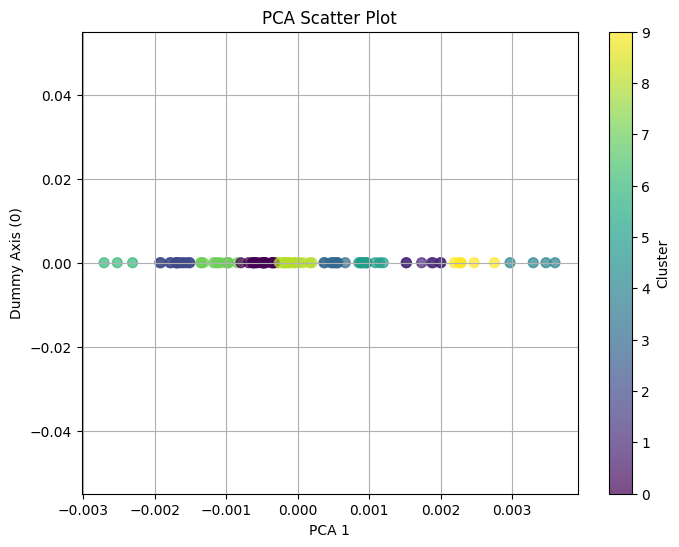

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

if X_pca.shape[1] == 1:
    # Only 1 component: plot X vs dummy zeros
    plt.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]), c=clusters, cmap='viridis', s=50, alpha=0.7)
    plt.xlabel("PCA 1")
    plt.ylabel("Dummy Axis (0)")
else:
    # 2 or more components: plot normally
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

plt.colorbar(label='Cluster')
plt.grid(True)
plt.title("PCA Scatter Plot")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/genriflow/autoencoder.pdf')
plt.show()

# Check Results

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Your predicted_labels and true_labels (processed like before)

# First, we must encode true_labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
true_labels_encoded = le.fit_transform(y)

# Now calculate ARI and NMI
ari = adjusted_rand_score(true_labels_encoded, clusters)
nmi = normalized_mutual_info_score(true_labels_encoded, clusters)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Adjusted Rand Index (ARI): -0.0081
Normalized Mutual Information (NMI): 0.2022
